In [51]:
#Step 1 Load the Data

# Time Series Forecasting - Multivariate Time Series Models for Crypto Order Book Market Prediction


import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Tensorflow Version: 2.9.1
Num GPUs: 0


In [59]:
df = pd.read_csv('20220812.csv')
df.head()

,id,symbol,sequence,ask_price,ask_size,bid_price,bid_size,time_coinapi,time_exchange,ts
0,fdc75135-e60f-4f12-9c51-890400af49c6,KUCOIN_SPOT_DOGE_KCS,11486.0,0.006679,18272.349500,0.006665,3380.659900,2022-08-12 17:05:40.14002,2022-08-12 17:05:40.14002,2022-08-12 17:05:48.591357
1,07a2b1e0-0da2-4527-aea5-46a407d5343c,BINANCEFTS_PERP_RUNE_USDT,48137.0,2.864000,11603.000000,2.863000,4023.000000,2022-08-12 17:05:48.517105,2022-08-12 17:05:48.366,2022-08-12 17:05:48.633554
2,75e4c1b4-98a9-497c-bd27-b77584fcf390,OKEX_SPOT_BCH_USDT,36271.0,140.410000,0.789202,140.400000,0.071009,2022-08-12 17:05:48.35,2022-08-12 17:05:48.35,2022-08-12 17:05:48.663045
3,00246367-0e1b-466c-a39b-f23469162251,BINANCE_SPOT_TRB_USDT,48881.0,40.820000,2.920000,40.790000,2.960000,2022-08-12 17:05:42.117928,2022-08-12 17:05:42.117928,2022-08-12 17:05:48.674947
4,7e118fc3-51d1-4cc7-a0f5-2f003dc0296d,BINANCEFTS_PERP_WAVES_USDT,55843.0,6.002000,4575.400000,6.001000,254.900000,2022-08-12 17:05:48.517981,2022-08-12 17:05:48.363,2022-08-12 17:05:48.683038


In [53]:
#Step 2 Exploring the Data

# set the indextimestamp
df.index = df.time_coinapi

df = df.drop(columns=['ts', 'time_exchange', 'time_coinapi', 'id', 'symbol'])

# Create a quick overview of the dataset
df.head()

,sequence,ask_price,ask_size,bid_price,bid_size
time_coinapi,,,,,
2022-08-12 17:05:40.14002,11486.0,0.006679,18272.349500,0.006665,3380.659900
2022-08-12 17:05:48.517105,48137.0,2.864000,11603.000000,2.863000,4023.000000
2022-08-12 17:05:48.35,36271.0,140.410000,0.789202,140.400000,0.071009
2022-08-12 17:05:42.117928,48881.0,40.820000,2.920000,40.790000,2.960000
2022-08-12 17:05:48.517981,55843.0,6.002000,4575.400000,6.001000,254.900000


In [60]:
#Step 3 Preprocessing and Feature Selection

# Indexing Batches
train_df = df.sort_values(by=['time_coinapi']).copy()
train_df = df.head(5000)
# List of considered Features
FEATURES = ['ask_price', 'ask_size', 'bid_price', 'bid_size', 'sequence'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['ask_price']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['ask_price', 'ask_size', 'bid_price', 'bid_size', 'sequence']


,ask_price,ask_size,bid_price,bid_size,sequence,Prediction
4995,24033.70,11.531553,24033.60,0.000100,128170.0,24033.70
4996,24016.00,0.020000,24011.20,0.624509,96485.0,24016.00
4997,24026.88,0.072617,24018.44,0.125000,81988.0,24026.88
4998,24014.30,0.190000,24011.20,0.624509,96486.0,24014.30
4999,24025.68,0.125000,24018.44,0.125000,81989.0,24025.68


In [61]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_ask_price = pd.DataFrame(data_filtered_ext['ask_price'])
np_ask_price_scaled = scaler_pred.fit_transform(df_ask_price)

(5000, 5)


In [62]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_ask_price = data.columns.get_loc("ask_price")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_ask_price]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last ask_ price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_ask_price])
print(y_train[0])

(3950, 50, 5) (3950,)
(1000, 50, 5) (1000,)
3.942977617291279e-05
3.942977617291279e-05


In [57]:
#Step 4 Model Training

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(GRU(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(GRU(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [63]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
247/247 [==============================] - 15s 59ms/step - loss: 1.4543e-04 - val_loss: 5.0997e-08
Epoch 2/50
247/247 [==============================] - 14s 58ms/step - loss: 1.6370e-07 - val_loss: 3.7395e-08
Epoch 3/50
247/247 [==============================] - 15s 59ms/step - loss: 1.3154e-07 - val_loss: 7.5017e-08
Epoch 4/50
247/247 [==============================] - 18s 74ms/step - loss: 1.1080e-07 - val_loss: 2.9003e-08
Epoch 5/50
247/247 [==============================] - 36s 145ms/step - loss: 1.1192e-07 - val_loss: 2.7623e-08
Epoch 6/50
247/247 [==============================] - 25s 101ms/step - loss: 9.2245e-08 - val_loss: 4.0672e-08
Epoch 7/50
247/247 [==============================] - 21s 83ms/step - loss: 8.5036e-08 - val_loss: 2.7453e-08
Epoch 8/50
247/247 [==============================] - 23s 92ms/step - loss: 7.8888e-08 - val_loss: 5.5328e-08
Epoch 9/50
247/247 [==============================] - 26s 104ms/step - loss: 8.2643e-08 - val_loss: 3.6900e-08
Epoch 1

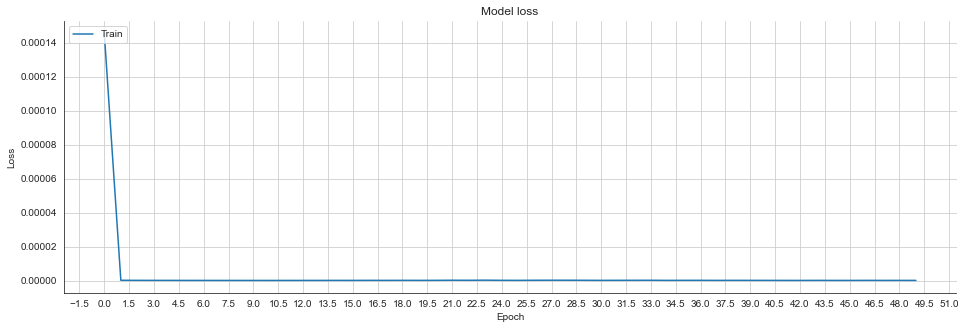

In [64]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [65]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

32/32 [==============================] - 1s 24ms/step
Median Absolute Error (MAE): 4.26
Mean Absolute Percentage Error (MAPE): 224929.16 %
Median Absolute Percentage Error (MDAPE): 1980.19 %


In [85]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)
#print(new_df)
N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['ask_price'].iat[-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The lask ask price is')
print(f'The predicted ask price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 27ms/step
The lask ask price is
The predicted ask price is 103.3499984741211 (-23542.2%)
